In [5]:
from notebook_utils import load_tinymodel, load_tinydataset, load_saes
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [148]:
llm = load_tinymodel()
dataset = load_tinydataset(batch_size=32, max_seq_length=128, num_datapoints=10000)
all_saes = load_saes(k=30)


100%|██████████| 10000/10000 [00:18<00:00, 548.03it/s]


Failed to tokenize 0 tokens
Number of datapoints w/ 129 tokens: 9473
Total Tokens: 1.222017M


/root/dictionary_learning/notebooks/notebook_utils.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path)


In [ ]:

# def load_module_names(llm):
#     module_names = []
#     for name, module in llm.named_modules():
#         module_names.append(name)
#     return module_names
# module_names = load_module_names(llm)

In [7]:
def calculate_gpu_memory(b, i, j, dtype=torch.float32):
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()
    
    input_features_memory = b * i * bytes_per_element
    virtual_weights_memory = i * j * bytes_per_element
    attribution_memory = b * i * j * bytes_per_element
    
    total_memory = input_features_memory + virtual_weights_memory + attribution_memory
    
    return {
        "input_features_memory": input_features_memory,
        "virtual_weights_memory": virtual_weights_memory,
        "attribution_memory": attribution_memory,
        "total_memory": total_memory,
        "total_memory_gb": total_memory / (1024**3)
    }

# Example usage
b = 1*128
i, j =  6500, 6500  # Your dimensions
memory_info = calculate_gpu_memory(b, i, j)

print(f"Input Features Memory: {memory_info['input_features_memory'] / (1024**2):.2f} MB")
print(f"Virtual Weights Memory: {memory_info['virtual_weights_memory'] / (1024**2):.2f} MB")
print(f"Attribution Memory: {memory_info['attribution_memory'] / (1024**2):.2f} MB")
print(f"Total Memory: {memory_info['total_memory_gb']:.2f} GB")

Input Features Memory: 3.17 MB
Virtual Weights Memory: 161.17 MB
Attribution Memory: 20629.88 MB
Total Memory: 20.31 GB


In [149]:
from einops import rearrange, einsum

def update_running_average_with_sum(current_avg, new_sum, current_count, new_count):
    """
    Update the running average with a new sum and count.
    
    :param current_avg: Current running average
    :param new_sum: Sum of new values to include in the average
    :param current_count: Number of values in the current average
    :param new_count: Number of new values
    :return: New running average, Updated total count
    """
    if current_count == 0:
        return new_sum / new_count, new_count
    
    total_count = current_count + new_count
    updated_sum = current_avg * current_count + new_sum
    updated_avg = updated_sum / total_count
    return updated_avg, total_count

target_sae_names = ['torso_1_mlp_out_transcoder', 'torso_1_res_final']
saes = [all_saes[name].to(device) for name in target_sae_names]
num_input_features = saes[0].encoder.weight.shape[0]
num_output_features = saes[1].encoder.weight.shape[0]
feature_by_feature_attribution = torch.zeros(num_input_features, num_output_features).to(device)
running_total_for_each_feature = torch.zeros(num_output_features).to(device)

resid_mid = llm.torso[1].res_mlp
resid_final = llm.torso[1].res_final
mlp_out = llm.torso[1].mlp
# for batch_ind, batch in enumerate(dataset):
# add tqdm to enumerate correctly
from tqdm import tqdm
entropy_across_batches = []
with torch.no_grad():
    for batch_ind, batch in enumerate(tqdm(dataset)):
        batch = batch.to(device)
        with llm.trace(batch) as tracr:
            act_res_mid = resid_mid.output.save()
            act_res_final = resid_final.output.save()
            act_mlp_out = mlp_out.output.save()
        # Now we want to run through the saes
        transcoder = saes[0].to(device)
        sae_final = saes[1].to(device)
        # mlp_out_hat = transcoder(act_res_mid)

        # sae_final_features_hat = sae_final.encode(mlp_out_hat+act_res_mid)
        # maybe figure out a way to fold in the decoder bias?
        tr_dec = transcoder.decoder.weight
        #TODO: we removed the last weight to help w/ knowing .T and shape. 
        final_enc = sae_final.encoder.weight
        virtual_weights = tr_dec.T @ final_enc.T

        act_res_mid = act_res_mid.to(device)
        act_res_mid = rearrange(act_res_mid, 'b s d_model -> (b s) d_model')
        input_features, input_acts, input_indices = transcoder.encode(act_res_mid, return_topk=True)
        # input_features = rearrange(input_features, 'b s f -> (b s) f')
        # input_acts = rearrange(input_acts, 'b s f-> (b s) f')
        # input_indices = rearrange(input_indices, 'b s f -> (b s) f')
        mlp_out_hat = transcoder.decoder(input_features)

        output_features, output_acts, output_indices = sae_final.encode(mlp_out_hat + act_res_mid, return_topk=True)

        # Gradient equals the weights
        # attribution = torch.einsum('bi,ij->bij', input_features, virtual_weights)
        # features_set_yet = torch.zeros(num_output_features, dtype=torch.bool)

        for current_output_feature in range(num_output_features):
            # Get the batch indices where the output feature is non-zero
            nz_batch_indices = (output_indices==current_output_feature).sum(-1).nonzero()[:, 0]
            output_virtual_weights = virtual_weights[:, current_output_feature]

            # Index into the virtual weights & input indices ie find the inputs that activated the output feature
            nz_input_ind = input_indices[nz_batch_indices]
            batched_virtual_weights = output_virtual_weights[nz_input_ind].to(device)
            nz_input_acts = input_acts[nz_batch_indices]

            # Calculate the attribution ie act*gradient
            current_output_attribution = nz_input_acts * batched_virtual_weights 

            # Set the feature by feature attribution (average w/ existing attributions)    
            averaged_current_output_attribution = current_output_attribution.mean(dim=0)
            
            # The new count is the number of non-zero batch indices for this feature
            new_count = len(nz_batch_indices)

            # Update the feature_by_feature_attribution using the running average with sum
            feature_by_feature_attribution[nz_input_ind, current_output_feature], running_total_for_each_feature[current_output_feature] = update_running_average_with_sum(
                current_avg = feature_by_feature_attribution[nz_input_ind, current_output_feature],
                new_sum = current_output_attribution,
                current_count = running_total_for_each_feature[current_output_feature],
                new_count = new_count
            )
        if(batch_ind %1 == 0):
            # Now we want to divide feature_by_feature_attribution by each of the times it activated
            alive_output_features = running_total_for_each_feature != 0

            averaged_feature_by_feature_attribution = feature_by_feature_attribution[:, alive_output_features] / running_total_for_each_feature[alive_output_features].unsqueeze(0)
            # Now we want to convert to a prob-dist and calculate entropy on it, ignoring dead features
            normed_feature_by_feature_attribution = averaged_feature_by_feature_attribution / averaged_feature_by_feature_attribution.abs().sum(dim=0)

            logged = normed_feature_by_feature_attribution.abs().log()
            logged[logged.isinf()] = 0
            entropy = -(normed_feature_by_feature_attribution.abs() * logged).sum(dim=0)
            entropy_across_batches.append(entropy.mean().item())
            print(f"Entropy: {entropy.mean().item()}")


  0%|          | 1/297 [00:03<19:37,  3.98s/it]

Entropy: 4.6019062995910645


  1%|          | 2/297 [00:08<19:53,  4.05s/it]

Entropy: 5.013808727264404


  1%|          | 3/297 [00:12<19:36,  4.00s/it]

Entropy: 5.252461910247803


  1%|▏         | 4/297 [00:15<18:44,  3.84s/it]

Entropy: 5.421160697937012


  2%|▏         | 5/297 [00:19<18:20,  3.77s/it]

Entropy: 5.536966323852539


  2%|▏         | 6/297 [00:22<17:58,  3.71s/it]

Entropy: 5.624728202819824


  2%|▏         | 7/297 [00:26<17:44,  3.67s/it]

Entropy: 5.6972174644470215


  3%|▎         | 8/297 [00:29<17:23,  3.61s/it]

Entropy: 5.754840850830078


  3%|▎         | 9/297 [00:33<17:32,  3.65s/it]

Entropy: 5.80457878112793


  3%|▎         | 10/297 [00:37<17:53,  3.74s/it]

Entropy: 5.848028182983398


  4%|▎         | 11/297 [00:41<17:40,  3.71s/it]

Entropy: 5.885636329650879


  4%|▍         | 12/297 [00:45<17:44,  3.73s/it]

Entropy: 5.918002128601074


  4%|▍         | 13/297 [00:48<17:29,  3.70s/it]

Entropy: 5.946206092834473


  5%|▍         | 14/297 [00:52<17:14,  3.65s/it]

Entropy: 5.971977710723877


  5%|▌         | 15/297 [00:55<17:18,  3.68s/it]

Entropy: 5.995954990386963


  5%|▌         | 16/297 [00:59<17:07,  3.66s/it]

Entropy: 6.017444133758545


  6%|▌         | 17/297 [01:03<16:58,  3.64s/it]

Entropy: 6.037295818328857


  6%|▌         | 18/297 [01:06<17:06,  3.68s/it]

Entropy: 6.055354118347168


  6%|▋         | 19/297 [01:10<16:50,  3.63s/it]

Entropy: 6.072602272033691


  7%|▋         | 20/297 [01:13<16:27,  3.57s/it]

Entropy: 6.090076446533203


  7%|▋         | 21/297 [01:17<16:24,  3.57s/it]

Entropy: 6.107024192810059


  7%|▋         | 22/297 [01:21<16:23,  3.58s/it]

Entropy: 6.121205806732178


  8%|▊         | 23/297 [01:24<16:29,  3.61s/it]

Entropy: 6.135374546051025


  8%|▊         | 24/297 [01:28<16:26,  3.61s/it]

Entropy: 6.148035526275635


  8%|▊         | 25/297 [01:31<16:23,  3.61s/it]

Entropy: 6.159493923187256


  9%|▉         | 26/297 [01:35<16:18,  3.61s/it]

Entropy: 6.170994758605957


  9%|▉         | 27/297 [01:39<16:11,  3.60s/it]

Entropy: 6.1819586753845215


  9%|▉         | 28/297 [01:42<16:01,  3.58s/it]

Entropy: 6.192153453826904


 10%|▉         | 29/297 [01:46<15:50,  3.55s/it]

Entropy: 6.2013397216796875


 10%|█         | 30/297 [01:49<15:57,  3.59s/it]

Entropy: 6.210585594177246


 10%|█         | 31/297 [01:53<15:56,  3.60s/it]

Entropy: 6.219674110412598


 11%|█         | 32/297 [01:56<15:46,  3.57s/it]

Entropy: 6.229183673858643


 11%|█         | 33/297 [02:00<15:45,  3.58s/it]

Entropy: 6.23756217956543


 11%|█▏        | 34/297 [02:04<15:43,  3.59s/it]

Entropy: 6.245084285736084


 12%|█▏        | 35/297 [02:07<15:32,  3.56s/it]

Entropy: 6.251889228820801


 12%|█▏        | 36/297 [02:11<15:34,  3.58s/it]

Entropy: 6.259177207946777


 12%|█▏        | 37/297 [02:14<15:18,  3.53s/it]

Entropy: 6.266119956970215


 13%|█▎        | 38/297 [02:18<15:44,  3.65s/it]

Entropy: 6.2727861404418945


 13%|█▎        | 39/297 [02:22<15:47,  3.67s/it]

Entropy: 6.278965950012207


 13%|█▎        | 40/297 [02:25<15:31,  3.62s/it]

Entropy: 6.285182476043701


 14%|█▍        | 41/297 [02:29<15:33,  3.65s/it]

Entropy: 6.290903091430664


 14%|█▍        | 42/297 [02:33<15:29,  3.65s/it]

Entropy: 6.296571254730225


 14%|█▍        | 43/297 [02:36<15:28,  3.66s/it]

Entropy: 6.3022613525390625


 15%|█▍        | 44/297 [02:40<15:21,  3.64s/it]

Entropy: 6.306918621063232


 15%|█▌        | 45/297 [02:44<15:25,  3.67s/it]

Entropy: 6.312348365783691


 15%|█▌        | 46/297 [02:47<15:26,  3.69s/it]

Entropy: 6.317654609680176


 16%|█▌        | 47/297 [02:51<15:17,  3.67s/it]

Entropy: 6.322332382202148


 16%|█▌        | 48/297 [02:55<15:13,  3.67s/it]

Entropy: 6.327293395996094


 16%|█▋        | 49/297 [02:59<15:31,  3.76s/it]

Entropy: 6.331892490386963


 17%|█▋        | 50/297 [03:02<15:16,  3.71s/it]

Entropy: 6.336668968200684


 17%|█▋        | 51/297 [03:06<15:13,  3.71s/it]

Entropy: 6.34138822555542


 18%|█▊        | 52/297 [03:10<15:00,  3.68s/it]

Entropy: 6.345682144165039


 18%|█▊        | 53/297 [03:13<14:49,  3.65s/it]

Entropy: 6.349698543548584


 18%|█▊        | 54/297 [03:17<14:47,  3.65s/it]

Entropy: 6.353908538818359


 19%|█▊        | 55/297 [03:20<14:29,  3.59s/it]

Entropy: 6.357517242431641


 19%|█▉        | 56/297 [03:24<14:34,  3.63s/it]

Entropy: 6.361351490020752


 19%|█▉        | 57/297 [03:28<14:31,  3.63s/it]

Entropy: 6.365324974060059


 20%|█▉        | 58/297 [03:31<14:23,  3.61s/it]

Entropy: 6.368999481201172


 20%|█▉        | 59/297 [03:35<14:13,  3.59s/it]

Entropy: 6.372711181640625


 20%|██        | 60/297 [03:38<14:08,  3.58s/it]

Entropy: 6.37627649307251


 21%|██        | 61/297 [03:42<14:08,  3.59s/it]

Entropy: 6.379827976226807


 21%|██        | 62/297 [03:46<14:13,  3.63s/it]

Entropy: 6.3829545974731445


 21%|██        | 63/297 [03:49<13:53,  3.56s/it]

Entropy: 6.386387348175049


 22%|██▏       | 64/297 [03:53<13:55,  3.59s/it]

Entropy: 6.389688491821289


 22%|██▏       | 65/297 [03:56<13:48,  3.57s/it]

Entropy: 6.393080234527588


 22%|██▏       | 66/297 [04:00<13:41,  3.56s/it]

Entropy: 6.396552562713623


 23%|██▎       | 67/297 [04:03<13:33,  3.54s/it]

Entropy: 6.3995585441589355


 23%|██▎       | 68/297 [04:07<13:34,  3.56s/it]

Entropy: 6.40273380279541


 23%|██▎       | 69/297 [04:10<13:25,  3.53s/it]

Entropy: 6.405427932739258


 24%|██▎       | 70/297 [04:14<13:30,  3.57s/it]

Entropy: 6.4081854820251465


 24%|██▍       | 71/297 [04:18<13:27,  3.57s/it]

Entropy: 6.411192893981934


 24%|██▍       | 72/297 [04:21<13:25,  3.58s/it]

Entropy: 6.413645267486572


 25%|██▍       | 73/297 [04:25<13:23,  3.59s/it]

Entropy: 6.416391372680664


 25%|██▍       | 74/297 [04:28<13:13,  3.56s/it]

Entropy: 6.418892860412598


 25%|██▌       | 75/297 [04:32<13:06,  3.54s/it]

Entropy: 6.4214630126953125


 26%|██▌       | 76/297 [04:35<13:13,  3.59s/it]

Entropy: 6.4239935874938965


 26%|██▌       | 77/297 [04:39<13:35,  3.71s/it]

Entropy: 6.426420211791992


 26%|██▋       | 78/297 [04:43<13:20,  3.65s/it]

Entropy: 6.428950309753418


 27%|██▋       | 79/297 [04:47<13:12,  3.64s/it]

Entropy: 6.431337833404541


 27%|██▋       | 80/297 [04:50<12:52,  3.56s/it]

Entropy: 6.43356466293335


 27%|██▋       | 81/297 [04:54<12:50,  3.57s/it]

Entropy: 6.436020851135254


 28%|██▊       | 82/297 [04:57<12:44,  3.56s/it]

Entropy: 6.438394546508789


 28%|██▊       | 83/297 [05:01<12:45,  3.58s/it]

Entropy: 6.4409565925598145


 28%|██▊       | 84/297 [05:05<13:21,  3.76s/it]

Entropy: 6.4430084228515625


 29%|██▊       | 85/297 [05:09<13:50,  3.92s/it]

Entropy: 6.445380687713623


 29%|██▉       | 86/297 [05:13<14:11,  4.04s/it]

Entropy: 6.447420597076416


 29%|██▉       | 87/297 [05:18<14:19,  4.09s/it]

Entropy: 6.449489116668701


 30%|██▉       | 88/297 [05:22<14:32,  4.17s/it]

Entropy: 6.451460361480713


 30%|██▉       | 89/297 [05:26<14:27,  4.17s/it]

Entropy: 6.453432083129883


 30%|███       | 90/297 [05:30<13:49,  4.01s/it]

Entropy: 6.4554290771484375


 31%|███       | 91/297 [05:33<13:10,  3.84s/it]

Entropy: 6.457250595092773


 31%|███       | 92/297 [05:37<12:52,  3.77s/it]

Entropy: 6.459177017211914


 31%|███▏      | 93/297 [05:40<12:36,  3.71s/it]

Entropy: 6.461000919342041


 32%|███▏      | 94/297 [05:44<12:37,  3.73s/it]

Entropy: 6.462841987609863


 32%|███▏      | 95/297 [05:48<12:27,  3.70s/it]

Entropy: 6.464639663696289


 32%|███▏      | 96/297 [05:52<12:20,  3.68s/it]

Entropy: 6.466277122497559


 33%|███▎      | 97/297 [05:55<12:10,  3.65s/it]

Entropy: 6.46816349029541


 33%|███▎      | 98/297 [05:59<12:07,  3.66s/it]

Entropy: 6.470128536224365


 33%|███▎      | 99/297 [06:02<12:06,  3.67s/it]

Entropy: 6.471836566925049


 34%|███▎      | 100/297 [06:06<12:10,  3.71s/it]

Entropy: 6.473741054534912


 34%|███▍      | 101/297 [06:10<12:12,  3.74s/it]

Entropy: 6.4753618240356445


 34%|███▍      | 102/297 [06:14<12:11,  3.75s/it]

Entropy: 6.477178573608398


 35%|███▍      | 103/297 [06:17<11:55,  3.69s/it]

Entropy: 6.478771209716797


 35%|███▌      | 104/297 [06:21<11:51,  3.69s/it]

Entropy: 6.480522155761719


 35%|███▌      | 105/297 [06:25<11:48,  3.69s/it]

Entropy: 6.482283115386963


 36%|███▌      | 106/297 [06:28<11:44,  3.69s/it]

Entropy: 6.483983516693115


 36%|███▌      | 107/297 [06:32<11:36,  3.67s/it]

Entropy: 6.4856414794921875


 36%|███▋      | 108/297 [06:36<11:39,  3.70s/it]

Entropy: 6.487205982208252


 37%|███▋      | 109/297 [06:39<11:30,  3.67s/it]

Entropy: 6.48890495300293


 37%|███▋      | 110/297 [06:43<11:34,  3.71s/it]

Entropy: 6.490471363067627


 37%|███▋      | 111/297 [06:47<11:40,  3.77s/it]

Entropy: 6.491923809051514


 38%|███▊      | 112/297 [06:51<11:34,  3.75s/it]

Entropy: 6.49326753616333


 38%|███▊      | 113/297 [06:55<11:27,  3.73s/it]

Entropy: 6.494739532470703


 38%|███▊      | 114/297 [06:58<11:27,  3.76s/it]

Entropy: 6.496330738067627


 39%|███▊      | 115/297 [07:02<11:19,  3.73s/it]

Entropy: 6.497791767120361


 39%|███▉      | 116/297 [07:06<11:14,  3.72s/it]

Entropy: 6.499151706695557


 39%|███▉      | 117/297 [07:09<11:04,  3.69s/it]

Entropy: 6.500448703765869


 40%|███▉      | 118/297 [07:13<10:54,  3.66s/it]

Entropy: 6.501816272735596


 40%|████      | 119/297 [07:17<10:59,  3.70s/it]

Entropy: 6.503171920776367


 40%|████      | 120/297 [07:20<10:56,  3.71s/it]

Entropy: 6.504556179046631


 41%|████      | 121/297 [07:24<10:46,  3.67s/it]

Entropy: 6.505866527557373


 41%|████      | 122/297 [07:28<10:54,  3.74s/it]

Entropy: 6.507228851318359


 41%|████▏     | 123/297 [07:32<10:54,  3.76s/it]

Entropy: 6.508492469787598


 42%|████▏     | 124/297 [07:36<10:49,  3.76s/it]

Entropy: 6.509705543518066


 42%|████▏     | 125/297 [07:39<10:35,  3.69s/it]

Entropy: 6.511117935180664


 42%|████▏     | 126/297 [07:43<10:29,  3.68s/it]

Entropy: 6.512387275695801


 43%|████▎     | 127/297 [07:46<10:29,  3.70s/it]

Entropy: 6.513679027557373


 43%|████▎     | 128/297 [07:50<10:20,  3.67s/it]

Entropy: 6.515023708343506


 43%|████▎     | 129/297 [07:54<10:14,  3.66s/it]

Entropy: 6.5162506103515625


 44%|████▍     | 130/297 [07:57<10:02,  3.61s/it]

Entropy: 6.517513275146484


 44%|████▍     | 131/297 [08:01<10:05,  3.65s/it]

Entropy: 6.518761157989502


 44%|████▍     | 132/297 [08:04<09:50,  3.58s/it]

Entropy: 6.51996374130249


 45%|████▍     | 133/297 [08:08<09:43,  3.56s/it]

Entropy: 6.521084785461426


 45%|████▌     | 134/297 [08:12<09:49,  3.62s/it]

Entropy: 6.5222487449646


 45%|████▌     | 135/297 [08:15<09:46,  3.62s/it]

Entropy: 6.523406505584717


 46%|████▌     | 136/297 [08:19<09:45,  3.64s/it]

Entropy: 6.524528503417969


 46%|████▌     | 137/297 [08:23<09:42,  3.64s/it]

Entropy: 6.525569915771484


 46%|████▋     | 138/297 [08:26<09:39,  3.65s/it]

Entropy: 6.526641845703125


 47%|████▋     | 139/297 [08:30<09:33,  3.63s/it]

Entropy: 6.527734279632568


 47%|████▋     | 140/297 [08:34<09:34,  3.66s/it]

Entropy: 6.528910160064697


 47%|████▋     | 141/297 [08:37<09:36,  3.70s/it]

Entropy: 6.530008316040039


 48%|████▊     | 142/297 [08:41<09:18,  3.60s/it]

Entropy: 6.531063079833984


 48%|████▊     | 143/297 [08:44<09:13,  3.59s/it]

Entropy: 6.53220796585083


 48%|████▊     | 144/297 [08:48<09:12,  3.61s/it]

Entropy: 6.533309459686279


 49%|████▉     | 145/297 [08:52<09:07,  3.60s/it]

Entropy: 6.534363746643066


 49%|████▉     | 146/297 [08:55<08:58,  3.57s/it]

Entropy: 6.53545618057251


 49%|████▉     | 147/297 [08:59<08:56,  3.57s/it]

Entropy: 6.53645658493042


 50%|████▉     | 148/297 [09:02<09:00,  3.62s/it]

Entropy: 6.537423610687256


 50%|█████     | 149/297 [09:06<08:58,  3.64s/it]

Entropy: 6.538393974304199


 51%|█████     | 150/297 [09:10<08:56,  3.65s/it]

Entropy: 6.539439678192139


 51%|█████     | 151/297 [09:13<08:55,  3.66s/it]

Entropy: 6.540396213531494


 51%|█████     | 152/297 [09:17<09:07,  3.78s/it]

Entropy: 6.541382789611816


 52%|█████▏    | 153/297 [09:21<08:59,  3.74s/it]

Entropy: 6.542479991912842


 52%|█████▏    | 154/297 [09:25<08:53,  3.73s/it]

Entropy: 6.543610095977783


 52%|█████▏    | 155/297 [09:28<08:43,  3.68s/it]

Entropy: 6.544554233551025


 53%|█████▎    | 156/297 [09:32<08:39,  3.69s/it]

Entropy: 6.54537296295166


 53%|█████▎    | 157/297 [09:36<08:31,  3.65s/it]

Entropy: 6.546234130859375


 53%|█████▎    | 158/297 [09:39<08:35,  3.71s/it]

Entropy: 6.547173023223877


 54%|█████▎    | 159/297 [09:43<08:33,  3.72s/it]

Entropy: 6.548068523406982


 54%|█████▍    | 160/297 [09:47<08:24,  3.69s/it]

Entropy: 6.549022674560547


 54%|█████▍    | 161/297 [09:50<08:08,  3.59s/it]

Entropy: 6.5499138832092285


 55%|█████▍    | 162/297 [09:54<08:06,  3.60s/it]

Entropy: 6.550824165344238


 55%|█████▍    | 163/297 [09:58<08:06,  3.63s/it]

Entropy: 6.551697731018066


 55%|█████▌    | 164/297 [10:01<08:01,  3.62s/it]

Entropy: 6.552578449249268


 56%|█████▌    | 165/297 [10:05<07:57,  3.62s/it]

Entropy: 6.553519248962402


 56%|█████▌    | 166/297 [10:08<07:51,  3.60s/it]

Entropy: 6.554316520690918


 56%|█████▌    | 167/297 [10:12<07:44,  3.57s/it]

Entropy: 6.555163860321045


 57%|█████▋    | 168/297 [10:15<07:39,  3.56s/it]

Entropy: 6.555984020233154


 57%|█████▋    | 169/297 [10:19<07:40,  3.60s/it]

Entropy: 6.556931018829346


 57%|█████▋    | 170/297 [10:23<07:31,  3.56s/it]

Entropy: 6.55778694152832


 58%|█████▊    | 171/297 [10:26<07:34,  3.61s/it]

Entropy: 6.55864143371582


 58%|█████▊    | 172/297 [10:30<07:31,  3.61s/it]

Entropy: 6.559535980224609


 58%|█████▊    | 173/297 [10:33<07:28,  3.62s/it]

Entropy: 6.560349464416504


 59%|█████▊    | 174/297 [10:37<07:27,  3.64s/it]

Entropy: 6.561136245727539


 59%|█████▉    | 175/297 [10:41<07:25,  3.65s/it]

Entropy: 6.561947822570801


 59%|█████▉    | 176/297 [10:44<07:20,  3.64s/it]

Entropy: 6.562758922576904


 60%|█████▉    | 177/297 [10:48<07:20,  3.67s/it]

Entropy: 6.563602447509766


 60%|█████▉    | 178/297 [10:52<07:19,  3.69s/it]

Entropy: 6.564403533935547


 60%|██████    | 179/297 [10:55<07:09,  3.64s/it]

Entropy: 6.5652031898498535


 61%|██████    | 180/297 [10:59<07:04,  3.63s/it]

Entropy: 6.565951347351074


 61%|██████    | 181/297 [11:03<06:59,  3.62s/it]

Entropy: 6.5667548179626465


 61%|██████▏   | 182/297 [11:06<06:56,  3.62s/it]

Entropy: 6.567470073699951


 62%|██████▏   | 183/297 [11:10<06:51,  3.61s/it]

Entropy: 6.568172931671143


 62%|██████▏   | 184/297 [11:14<06:49,  3.63s/it]

Entropy: 6.568896770477295


 62%|██████▏   | 185/297 [11:17<06:42,  3.60s/it]

Entropy: 6.569651126861572


 63%|██████▎   | 186/297 [11:21<06:35,  3.57s/it]

Entropy: 6.570399284362793


 63%|██████▎   | 187/297 [11:24<06:33,  3.57s/it]

Entropy: 6.5711989402771


 63%|██████▎   | 188/297 [11:28<06:29,  3.58s/it]

Entropy: 6.571893692016602


 64%|██████▎   | 189/297 [11:31<06:27,  3.59s/it]

Entropy: 6.572530746459961


 64%|██████▍   | 190/297 [11:35<06:24,  3.60s/it]

Entropy: 6.573238849639893


 64%|██████▍   | 191/297 [11:39<06:21,  3.60s/it]

Entropy: 6.573971748352051


 65%|██████▍   | 192/297 [11:42<06:21,  3.63s/it]

Entropy: 6.574687480926514


 65%|██████▍   | 193/297 [11:46<06:20,  3.66s/it]

Entropy: 6.5754313468933105


 65%|██████▌   | 194/297 [11:50<06:17,  3.67s/it]

Entropy: 6.576186656951904


 66%|██████▌   | 195/297 [11:53<06:13,  3.66s/it]

Entropy: 6.576908111572266


 66%|██████▌   | 196/297 [11:57<06:10,  3.67s/it]

Entropy: 6.577602863311768


 66%|██████▋   | 197/297 [12:01<06:03,  3.64s/it]

Entropy: 6.578331470489502


 67%|██████▋   | 198/297 [12:04<06:01,  3.66s/it]

Entropy: 6.578949928283691


 67%|██████▋   | 199/297 [12:08<06:01,  3.69s/it]

Entropy: 6.579595565795898


 67%|██████▋   | 200/297 [12:12<05:55,  3.67s/it]

Entropy: 6.580244541168213


 68%|██████▊   | 201/297 [12:15<05:47,  3.62s/it]

Entropy: 6.580898284912109


 68%|██████▊   | 202/297 [12:19<05:46,  3.64s/it]

Entropy: 6.581531524658203


 68%|██████▊   | 203/297 [12:22<05:41,  3.63s/it]

Entropy: 6.582156658172607


 69%|██████▊   | 204/297 [12:26<05:39,  3.65s/it]

Entropy: 6.582777500152588


 69%|██████▉   | 205/297 [12:30<05:33,  3.63s/it]

Entropy: 6.583491325378418


 69%|██████▉   | 206/297 [12:33<05:30,  3.63s/it]

Entropy: 6.584157943725586


 70%|██████▉   | 207/297 [12:37<05:28,  3.65s/it]

Entropy: 6.584805011749268


 70%|███████   | 208/297 [12:41<05:26,  3.67s/it]

Entropy: 6.585461616516113


 70%|███████   | 209/297 [12:44<05:23,  3.68s/it]

Entropy: 6.586156368255615


 71%|███████   | 210/297 [12:48<05:19,  3.67s/it]

Entropy: 6.5867695808410645


 71%|███████   | 211/297 [12:52<05:14,  3.66s/it]

Entropy: 6.587451457977295


 71%|███████▏  | 212/297 [12:55<05:09,  3.65s/it]

Entropy: 6.588086128234863


 72%|███████▏  | 213/297 [12:59<05:09,  3.68s/it]

Entropy: 6.588723182678223


 72%|███████▏  | 214/297 [13:03<05:08,  3.71s/it]

Entropy: 6.589366912841797


 72%|███████▏  | 215/297 [13:07<05:01,  3.68s/it]

Entropy: 6.589947700500488


 73%|███████▎  | 216/297 [13:10<04:54,  3.64s/it]

Entropy: 6.590611934661865


 73%|███████▎  | 217/297 [13:14<04:52,  3.66s/it]

Entropy: 6.591202259063721


 73%|███████▎  | 218/297 [13:18<04:51,  3.69s/it]

Entropy: 6.591790676116943


 74%|███████▎  | 219/297 [13:21<04:43,  3.63s/it]

Entropy: 6.592392444610596


 74%|███████▍  | 220/297 [13:25<04:38,  3.62s/it]

Entropy: 6.5930023193359375


 74%|███████▍  | 221/297 [13:28<04:35,  3.63s/it]

Entropy: 6.593626976013184


 75%|███████▍  | 222/297 [13:32<04:33,  3.65s/it]

Entropy: 6.594297409057617


 75%|███████▌  | 223/297 [13:36<04:33,  3.70s/it]

Entropy: 6.594924449920654


 75%|███████▌  | 224/297 [13:39<04:29,  3.70s/it]

Entropy: 6.595523357391357


 76%|███████▌  | 225/297 [13:43<04:28,  3.73s/it]

Entropy: 6.59606409072876


 76%|███████▌  | 226/297 [13:47<04:23,  3.72s/it]

Entropy: 6.596643447875977


 76%|███████▋  | 227/297 [13:51<04:19,  3.71s/it]

Entropy: 6.5972089767456055


 77%|███████▋  | 228/297 [13:54<04:14,  3.68s/it]

Entropy: 6.597804069519043


 77%|███████▋  | 229/297 [13:58<04:08,  3.65s/it]

Entropy: 6.598364353179932


 77%|███████▋  | 230/297 [14:02<04:10,  3.73s/it]

Entropy: 6.598906517028809


 78%|███████▊  | 231/297 [14:05<04:04,  3.71s/it]

Entropy: 6.599515438079834


 78%|███████▊  | 232/297 [14:09<03:59,  3.69s/it]

Entropy: 6.60009241104126


 78%|███████▊  | 233/297 [14:13<03:54,  3.66s/it]

Entropy: 6.600650310516357


 79%|███████▉  | 234/297 [14:16<03:49,  3.64s/it]

Entropy: 6.601309299468994


 79%|███████▉  | 235/297 [14:20<03:44,  3.62s/it]

Entropy: 6.601834297180176


 79%|███████▉  | 236/297 [14:23<03:39,  3.59s/it]

Entropy: 6.60231351852417


 80%|███████▉  | 237/297 [14:27<03:35,  3.60s/it]

Entropy: 6.60280704498291


 80%|████████  | 238/297 [14:31<03:31,  3.59s/it]

Entropy: 6.603311061859131


 80%|████████  | 239/297 [14:34<03:27,  3.57s/it]

Entropy: 6.603893280029297


 81%|████████  | 240/297 [14:38<03:23,  3.58s/it]

Entropy: 6.604425430297852


 81%|████████  | 241/297 [14:41<03:21,  3.60s/it]

Entropy: 6.604897499084473


 81%|████████▏ | 242/297 [14:45<03:18,  3.61s/it]

Entropy: 6.605400085449219


 82%|████████▏ | 243/297 [14:49<03:14,  3.61s/it]

Entropy: 6.605947017669678


 82%|████████▏ | 244/297 [14:52<03:11,  3.62s/it]

Entropy: 6.606469631195068


 82%|████████▏ | 245/297 [14:56<03:10,  3.66s/it]

Entropy: 6.607003211975098


 83%|████████▎ | 246/297 [14:59<03:04,  3.62s/it]

Entropy: 6.607460021972656


 83%|████████▎ | 247/297 [15:03<03:03,  3.66s/it]

Entropy: 6.607953071594238


 84%|████████▎ | 248/297 [15:07<02:59,  3.67s/it]

Entropy: 6.608480453491211


 84%|████████▍ | 249/297 [15:10<02:54,  3.63s/it]

Entropy: 6.608996868133545


 84%|████████▍ | 250/297 [15:14<02:51,  3.65s/it]

Entropy: 6.609491348266602


 85%|████████▍ | 251/297 [15:18<02:47,  3.64s/it]

Entropy: 6.609989643096924


 85%|████████▍ | 252/297 [15:21<02:44,  3.65s/it]

Entropy: 6.610555648803711


 85%|████████▌ | 253/297 [15:25<02:38,  3.61s/it]

Entropy: 6.611053943634033


 86%|████████▌ | 254/297 [15:29<02:34,  3.59s/it]

Entropy: 6.611571311950684


 86%|████████▌ | 255/297 [15:32<02:32,  3.63s/it]

Entropy: 6.612060070037842


 86%|████████▌ | 256/297 [15:36<02:27,  3.60s/it]

Entropy: 6.612536430358887


 87%|████████▋ | 257/297 [15:40<02:26,  3.66s/it]

Entropy: 6.613034725189209


 87%|████████▋ | 258/297 [15:43<02:23,  3.68s/it]

Entropy: 6.613509654998779


 87%|████████▋ | 259/297 [15:47<02:19,  3.68s/it]

Entropy: 6.614010810852051


 88%|████████▊ | 260/297 [15:51<02:16,  3.69s/it]

Entropy: 6.6144938468933105


 88%|████████▊ | 261/297 [15:54<02:11,  3.66s/it]

Entropy: 6.615018844604492


 88%|████████▊ | 262/297 [15:58<02:07,  3.64s/it]

Entropy: 6.615475654602051


 89%|████████▊ | 263/297 [16:02<02:03,  3.64s/it]

Entropy: 6.6159348487854


 89%|████████▉ | 264/297 [16:05<01:59,  3.62s/it]

Entropy: 6.616417407989502


 89%|████████▉ | 265/297 [16:09<01:57,  3.67s/it]

Entropy: 6.616879940032959


 90%|████████▉ | 266/297 [16:13<01:54,  3.68s/it]

Entropy: 6.617344856262207


 90%|████████▉ | 267/297 [16:16<01:49,  3.66s/it]

Entropy: 6.617781639099121


 90%|█████████ | 268/297 [16:20<01:45,  3.64s/it]

Entropy: 6.618200778961182


 91%|█████████ | 269/297 [16:23<01:42,  3.66s/it]

Entropy: 6.618668556213379


 91%|█████████ | 270/297 [16:27<01:38,  3.64s/it]

Entropy: 6.619110107421875


 91%|█████████ | 271/297 [16:31<01:34,  3.63s/it]

Entropy: 6.619598865509033


 92%|█████████▏| 272/297 [16:34<01:31,  3.65s/it]

Entropy: 6.620059490203857


 92%|█████████▏| 273/297 [16:38<01:27,  3.63s/it]

Entropy: 6.620479583740234


 92%|█████████▏| 274/297 [16:41<01:22,  3.58s/it]

Entropy: 6.620945930480957


 93%|█████████▎| 275/297 [16:45<01:19,  3.60s/it]

Entropy: 6.6214423179626465


 93%|█████████▎| 276/297 [16:49<01:15,  3.61s/it]

Entropy: 6.621847629547119


 93%|█████████▎| 277/297 [16:52<01:12,  3.64s/it]

Entropy: 6.622287750244141


 94%|█████████▎| 278/297 [16:56<01:09,  3.67s/it]

Entropy: 6.6226806640625


 94%|█████████▍| 279/297 [17:00<01:05,  3.64s/it]

Entropy: 6.623119831085205


 94%|█████████▍| 280/297 [17:03<01:01,  3.62s/it]

Entropy: 6.623559474945068


 95%|█████████▍| 281/297 [17:07<00:58,  3.65s/it]

Entropy: 6.623980522155762


 95%|█████████▍| 282/297 [17:11<00:55,  3.72s/it]

Entropy: 6.6244025230407715


 95%|█████████▌| 283/297 [17:14<00:51,  3.65s/it]

Entropy: 6.62485933303833


 96%|█████████▌| 284/297 [17:18<00:47,  3.64s/it]

Entropy: 6.625260829925537


 96%|█████████▌| 285/297 [17:22<00:43,  3.63s/it]

Entropy: 6.625650882720947


 96%|█████████▋| 286/297 [17:25<00:40,  3.64s/it]

Entropy: 6.6260833740234375


 97%|█████████▋| 287/297 [17:29<00:36,  3.62s/it]

Entropy: 6.626458168029785


 97%|█████████▋| 288/297 [17:32<00:32,  3.63s/it]

Entropy: 6.626872539520264


 97%|█████████▋| 289/297 [17:36<00:29,  3.65s/it]

Entropy: 6.627291202545166


 98%|█████████▊| 290/297 [17:40<00:25,  3.63s/it]

Entropy: 6.627765655517578


 98%|█████████▊| 291/297 [17:44<00:22,  3.68s/it]

Entropy: 6.628192901611328


 98%|█████████▊| 292/297 [17:47<00:18,  3.69s/it]

Entropy: 6.628569602966309


 99%|█████████▊| 293/297 [17:51<00:14,  3.73s/it]

Entropy: 6.629022121429443


 99%|█████████▉| 294/297 [17:55<00:11,  3.74s/it]

Entropy: 6.629427909851074


 99%|█████████▉| 295/297 [17:59<00:07,  3.76s/it]

Entropy: 6.629866123199463


100%|█████████▉| 296/297 [18:02<00:03,  3.73s/it]

Entropy: 6.630290985107422


100%|██████████| 297/297 [18:04<00:00,  3.65s/it]

Entropy: 6.630242347717285


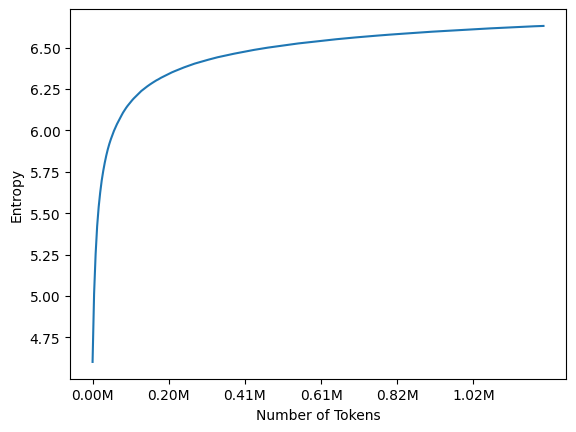

In [156]:
# Plot entropy_across_batches
import matplotlib.pyplot as plt
plt.plot(entropy_across_batches)
plt.xlabel("Number of Tokens")
plt.ylabel("Entropy")
# Set x indicies to be in increments of 10 to make it easier to read
# Each tick is 128*32 tokens
# Measure as M of tokens
n_ticks = 50
plt.xticks(range(0, len(entropy_across_batches), n_ticks), [f"{i*128*32/1e6:.2f}M" for i in range(0, len(entropy_across_batches), n_ticks)])
plt.show()

In [145]:
entropy_across_batches

[6.206844329833984]

In [141]:
# Now we want to divide feature_by_feature_attribution by each of the times it activated
alive_output_features = running_total_for_each_feature != 0

averaged_feature_by_feature_attribution = feature_by_feature_attribution[:, alive_output_features] / running_total_for_each_feature[alive_output_features].unsqueeze(0)
# Now we want to convert to a prob-dist and calculate entropy on it, ignoring dead features
normed_feature_by_feature_attribution = averaged_feature_by_feature_attribution / averaged_feature_by_feature_attribution.abs().sum(dim=0)

logged = normed_feature_by_feature_attribution.abs().log()
logged[logged.isinf()] = 0
entropy = -(normed_feature_by_feature_attribution.abs() * logged).sum(dim=0)
entropy.mean()

tensor(6.2069, device='cuda:0')

In [124]:
(running_total_for_each_feature[alive_output_features] == 0).any(), running_total_for_each_feature[alive_output_features].isnan().any(), feature_by_feature_attribution.isnan().any(), normed_feature_by_feature_attribution.isnan().any(), entropy.isnan().any(), averaged_feature_by_feature_attribution.isnan().any(), (averaged_feature_by_feature_attribution == 0).any()

(tensor(False, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(True, device='cuda:0'))

In [110]:
logged[logged.isnan()], logged.isnan().nonzero()
normed_feature_by_feature_attribution.abs()[0, 23]

tensor(nan, device='cuda:0')

In [93]:
torch.log(p1)

tensor([    -inf,     -inf,     -inf,  ..., -10.5742,     -inf,     -inf],
       device='cuda:0')

In [79]:
for N in range(10):
    assert (normed_feature_by_feature_attribution[:, N] == feature_by_feature_attribution[:, N] / running_total_for_each_feature[N]).all()

In [10]:
output_acts[output_indices==0]
input_acts[output_indices==0]
(output_indices==0).sum(-1) != 0, input_acts.shape

(tensor([False, False, False,  ..., False, False, False], device='cuda:0'),
 torch.Size([4128, 30]))

In [11]:
((output_indices==0).sum(-1) != 0).nonzero()

tensor([[2369],
        [3193],
        [3194],
        [3204],
        [3207],
        [3798]], device='cuda:0')

In [39]:
current_output_feature = 0
num_input_features = input_features.shape[-1]
num_output_features = output_features.shape[-1]
feature_by_feature_attribution = torch.zeros(num_input_features, num_output_features).to(device)
# features_set_yet = torch.zeros(num_output_features, dtype=torch.bool)
iteration = 1

for current_output_feature in range(num_output_features):
    # Get the batch indices where the output feature is non-zero
    nz_batch_indices = (output_indices==current_output_feature).sum(-1).nonzero()[:, 0]
    output_virtual_weights = virtual_weights[:, current_output_feature]

    # Index into the virtual weights & input indices ie find the inputs that activated the output feature
    nz_input_ind = input_indices[nz_batch_indices]
    batched_virtual_weights = output_virtual_weights[nz_input_ind].to(device)
    nz_input_acts = input_acts[nz_batch_indices]

    # Calculate the attribution ie act*gradient
    current_output_attribution = nz_input_acts * batched_virtual_weights 

    # Set the feature by feature attribution (average w/ existing attributions)    
    averaged_current_output_attribution = current_output_attribution.mean(dim=0)
    tmp_feature_list = torch.zeros(num_input_features).to(device)
    # Assign the averaged attributions to the correct input features
    # tmp_feature_list[nz_input_ind] = averaged_current_output_attribution

    feature_by_feature_attribution[nz_input_ind, current_output_feature] += averaged_current_output_attribution

# Normalize the attributions (by abs value cause negative gradients)
# total_abs_value = current_output_attribution.abs().sum(dim=-1)
# normed_current_output_attribution = current_output_attribution / total_abs_value[:, None]


In [106]:
normed_current_output_attribution.abs().sum(dim=-1), normed_current_output_attribution.mean(dim=0).abs().sum(dim=-1)

(tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 tensor(0.7414, device='cuda:0'))

In [110]:
normed_current_output_attribution.abs().mean(dim=0).abs().sum()

tensor(1., device='cuda:0')

In [105]:
normed_current_output_attribution.shape

torch.Size([6, 30])

In [96]:
total_abs_value = current_output_attribution.abs().sum(dim=-1)
# Normalize: 
normed_current_output_attribution = current_output_attribution / total_abs_value[:, None]

AssertionError: 

In [100]:
normed_current_output_attribution

tensor([[-3.6227e-02, -2.6679e-03, -2.5494e-02, -1.2283e-03,  1.7044e-01,
         -4.9746e-02, -1.8890e-02, -6.3689e-02, -3.3854e-02,  1.7237e-01,
         -6.0978e-03,  2.1763e-02, -4.3416e-02,  7.5457e-02,  2.9024e-02,
         -6.1067e-03,  5.2058e-03, -3.8862e-02, -6.2616e-03, -1.0429e-02,
         -2.1213e-02, -3.2377e-02, -2.1631e-02,  1.1801e-02, -4.8583e-02,
          7.9568e-03,  3.5445e-03, -9.7144e-03, -1.8767e-02, -7.1831e-03],
        [-1.3719e-02,  2.5239e-03,  4.5559e-01,  6.0995e-03,  1.5561e-01,
         -4.0269e-02, -1.2523e-02, -4.5647e-02,  6.8993e-03, -1.0656e-02,
         -5.3215e-02, -1.6520e-02, -9.7398e-03,  2.4028e-03, -1.1964e-02,
         -5.8181e-03, -1.9840e-02, -1.1012e-03, -1.8136e-02,  2.4025e-03,
          2.2144e-04,  1.3957e-02, -2.2930e-02,  9.7942e-03, -1.6925e-02,
         -5.8936e-03, -6.2075e-03,  1.3838e-02, -1.9537e-02,  2.1156e-05],
        [-9.3610e-02,  2.0581e-03,  2.8441e-03, -1.7609e-02,  3.2889e-01,
          2.9626e-03, -5.8919e-03, -

In [97]:
normed_current_output_attribution.norm(dim=-1)

tensor([0.2906, 0.4918, 0.3760, 0.3835, 0.3477, 0.5571], device='cuda:0')

In [95]:
current_output_attribution[0].abs().sum()

tensor(4.4699, device='cuda:0')

In [7]:
unique_input_indices = torch.unique(input_indices)
input_features[:, unique_input_indices].isnan().any()
unique_output_indices = torch.unique(output_indices)

# output_features.shape, unique_output_indices.shape
# virtual_weights[unique_input_indices][:, unique_output_indices]

In [9]:
virtual_weights.shape, unique_output_indices.max()

(torch.Size([6144, 6143]), tensor(6143, device='cuda:0'))

In [12]:
import torch
from einops import rearrange, einsum


def sparse_attribution(input_features, virtual_weights, input_indices, output_indices):
    # Find unique input and output indices across the batch
    unique_input_indices = torch.unique(input_indices)
    unique_output_indices = torch.unique(output_indices)

    # combine batch and sequence dimensions
    input_features = rearrange(input_features, 'b s i -> (b s) i')

    # Extract relevant slices of input_features and virtual_weights
    sparse_input_features = input_features[:, unique_input_indices]
    sparse_virtual_weights = virtual_weights[unique_input_indices][:, unique_output_indices]

    # Perform the sparse matrix multiplication
    sparse_attribution = torch.einsum('bi,ij->bij', sparse_input_features, sparse_virtual_weights)

    # Create a tensor to hold the full attribution
    full_attribution = torch.zeros(input_features.shape[0], input_features.shape[1], virtual_weights.shape[1], device=input_features.device)

    # Place the sparse attribution results in the correct positions in the full attribution tensor
    full_attribution[:, unique_input_indices[:, None], unique_output_indices] = sparse_attribution

    return full_attribution

# Usage
# Assuming input_features, virtual_weights, input_indices, and output_indices are defined
# attribution = sparse_attribution(input_features, virtual_weights, input_indices, output_indices)

unique_input_indices = torch.unique(input_indices)
unique_output_indices = torch.unique(output_indices)

# Extract relevant slices of input_features and virtual_weights
sparse_input_features = input_features[:, unique_input_indices]
sparse_virtual_weights = virtual_weights[unique_input_indices][:, unique_output_indices]

# Perform the sparse matrix multiplication
spar_attr = torch.einsum('bi,ij->bij', sparse_input_features, sparse_virtual_weights)

# # Create a tensor to hold the full attribution
# full_attribution = torch.zeros(input_features.shape[0], input_features.shape[1], virtual_weights.shape[1], device=input_features.device)

# # Place the sparse attribution results in the correct positions in the full attribution tensor
# full_attribution[:, unique_input_indices[:, None], unique_output_indices] = spar_attr


OutOfMemoryError: CUDA out of memory. Tried to allocate 795.99 GiB. GPU 0 has a total capacity of 15.73 GiB of which 14.37 GiB is free. Process 2007258 has 1.35 GiB memory in use. Of the allocated memory 1.07 GiB is allocated by PyTorch, and 93.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
input_features.shape, unique_input_indices.shape, unique_output_indices.shape

(torch.Size([8256, 6144]), torch.Size([4292]), torch.Size([6030]))

In [6]:
sparse_input_features.shape, sparse_virtual_weights.shape

(torch.Size([8256, 4292]), torch.Size([4292, 6030]))

In [4]:
print("input_features shape:", input_features.shape)
unique_input_indices = torch.unique(input_indices)
print("unique_input_indices shape:", unique_input_indices.shape)
print("Max value in unique_input_indices:", unique_input_indices.max().item())
print("Min value in unique_input_indices:", unique_input_indices.min().item())

input_features shape: torch.Size([64, 129, 6144])
unique_input_indices shape: torch.Size([4292])
Max value in unique_input_indices: 6142
Min value in unique_input_indices: 0


In [11]:

unique_input_indices = input_indices.unique()
unique_output_indices = output_indices.unique()

# # Extract relevant slices of input_features and virtual_weights
sparse_input_features = input_features[:, unique_input_indices]
sparse_virtual_weights = virtual_weights[unique_input_indices][:, unique_output_indices]
# sparse_input_features

In [7]:
uniq = input_indices.unique().cpu().numpy()
uniq

(4292,)

In [8]:
input_features.index([0,1], dim=-1)

AttributeError: 'Tensor' object has no attribute 'index'

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [38]:
from einops import rearrange, einsum
input_features = rearrange(input_features, 'b s f -> (b s) f')
attribution = einsum(input_features, virtual_weights, "b f1, f1 f2 -> b f1 f2")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1160.81 GiB. GPU 0 has a total capacity of 15.73 GiB of which 13.95 GiB is free. Process 1969018 has 1.78 GiB memory in use. Of the allocated memory 1.55 GiB is allocated by PyTorch, and 37.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
attribution = torch.dot(input_features, virtual_weights)
# RuntimeError: self must be a matrix
# attribution = input_features * virtual_weights

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [32]:
input_features.shape, virtual_weights.shape
attribution = torch.einsum('bi,ij->bij', input_features, virtual_weights)


(torch.Size([8256, 6144]), torch.Size([6144, 6143]))

In [5]:
attribution = rearrange(attribution, 'b s f -> (b s) f')

In [15]:
attribution.shape

torch.Size([64, 129, 6143])

In [6]:
output_indices = rearrange(output_indices, 'b s f -> (b s) f')

In [13]:
output_indices[:, 0].shape

torch.Size([64, 30])

In [8]:
with torch.no_grad():
    attribution = input_features @ virtual_weights

In [9]:
input_features.shape, virtual_weights.shape

(torch.Size([64, 129, 6144]), torch.Size([6144, 6143]))

In [10]:
# We want to calculate attribution = act*gradient

# I believe this is equivalent to the weights of the activations (ignore biases)
# It'd be good to actually verify this is the case



with torch.no_grad():
    tr_dec = transcoder.decoder.weight
    #TODO: we removed the last weight to help w/ knowing .T and shape. 
    final_enc = sae_final.encoder.weight[:-1]
    virtual_weights = tr_dec.T @ final_enc.T

    act_res_mid = act_res_mid.to(device)
    input_features, input_acts, input_indices = transcoder.encode(act_res_mid, return_topk=True)
    mlp_out_hat = transcoder.decoder(input_features)

    output_features, output_acts, output_indices = sae_final.encode(mlp_out_hat + act_res_mid, return_topk=True)

    # For efficient gradient calculation, we can get the nonzero_indices of both input & output feature

    # W_input = transcoder.decoder.weight[input_indices]    

In [12]:
transcoder.decoder.weight.shape, input_indices.shape

(torch.Size([768, 6144]), torch.Size([64, 129, 30]))

In [ ]:
# def encode(self, x: torch.Tensor, return_topk: bool = False):
#     post_relu_feat_acts_BF = nn.functional.relu(self.encoder(x - self.b_dec))
#     post_topk = post_relu_feat_acts_BF.topk(self.k, sorted=False, dim=-1)

#     # We can't split immediately due to nnsight
#     tops_acts_BK = post_topk.values
#     top_indices_BK = post_topk.indices

#     buffer_BF = torch.zeros_like(post_relu_feat_acts_BF)
#     encoded_acts_BF = buffer_BF.scatter_(dim=-1, index=top_indices_BK, src=tops_acts_BK)

#     if return_topk:
#         return encoded_acts_BF, tops_acts_BK, top_indices_BK
#     else:
#         return encoded_acts_BF

# def decode(self, x: torch.Tensor) -> torch.Tensor:
#     return self.decoder(x) + self.b_dec